# Vision Transformer for Weather Prediction

This notebook demonstrates how to build, train, and evaluate a Vision Transformer (ViT) model for weather prediction using gridded atmospheric data. The workflow includes data loading, preprocessing, model definition, training, evaluation, and visualization of results.

## Table of Contents
1. Data Loading and Preprocessing
2. Dataset Preparation
3. Data Splitting and DataLoader Setup
4. Vision Transformer Model Components
5. Model Training and Validation
6. Evaluation and Visualization
7. Per-pixel RMSE Analysis

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
from huggingface_hub import hf_hub_download

## 1. Data Loading and Preprocessing

This section imports required libraries and loads the weather dataset from the Hugging Face Hub. The data is loaded into an xarray dataset for easy manipulation and visualization.

In [2]:
path_20cr = hf_hub_download(repo_id="Mignar/weather-data", filename="air.2m.1981.nc", repo_type="dataset")

# We load the data into xarray datasets
ds_20cr = xr.open_dataset(path_20cr)
ds_20cr["air"]

<xarray.DataArray 'air' (time: 2920, lat: 181, lon: 360)> Size: 761MB
[190267200 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 724B -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time     (time) datetime64[ns] 23kB 1981-01-01 ... 1981-12-31T21:00:00
Attributes: (12/14)
    long_name:         3-hourly Air Temperature at 2 m
    units:             degK
    GRIB_name:         TMP
    dataset:           NOAA/CIRES/DOE 20th Century Reanalysis version 3mo
    level_desc:        2 m
    statistic:         Ensemble Mean
    ...                ...
    valid_range:       [100. 500.]
    statistic_method:  Ensemble mean is calculated by averaging over all 80 e...
    GridType:          Cylindrical Equidistant Projection Grid
    datum:             wgs84
    actual_range:      [208.67305 323.12778]
    var_desc:          Air temperature

In [3]:
def create_dataset(ds, field_name='air'):
    n_time, n_lon, n_lat = ds[field_name].shape

    data = torch.as_tensor(ds[field_name].values.reshape(n_time, 1, n_lon, n_lat))
    data = F.interpolate(data, size=(72, 72), mode='bilinear', align_corners=False)
    data = (data - 273.15) / 20.5
    
    targets = torch.clone(data[1:,:,:,:])
    data = data[:-1,:,:,:]
    
    dataset = torch.utils.data.TensorDataset(data, targets)

    return dataset, n_time-1

data_20cr, n_time = create_dataset(ds_20cr)

## 2. Dataset Preparation

Here, the dataset is converted into PyTorch tensors and normalized. Input-target pairs are created for weather prediction, allowing for configurable prediction horizons.

In [45]:
def create_prediction_dataset(ds, field_name='air', time_ahead=1):
    """
    Create a dataset for weather prediction with configurable prediction horizon.
    
    Args:
        ds: xarray Dataset containing weather data
        field_name: name of the variable to use (default: 'air')
        time_ahead: number of time steps to predict ahead (default: 1)
    """
    n_time, n_lon, n_lat = ds[field_name].shape
    
    # Create input-target pairs for timesteps
    # Input: data at time t, Target: data at time t+time_ahead
    data = torch.as_tensor(ds[field_name].values.reshape(n_time, 1, n_lon, n_lat))
    data = F.interpolate(data, size=(72, 72), mode='bilinear', align_corners=False)
    
    # Normalize the data
    data = (data - data.mean()) / data.std()
    
    # Create pairs of timesteps separated by time_ahead steps
    # inputs will be all timesteps except the last time_ahead ones
    # targets will be all timesteps from time_ahead onwards
    inputs = data[:-time_ahead]  # from t=0 to t=n-time_ahead
    targets = torch.clone(data[time_ahead:])  # from t=time_ahead to t=n
    
    # Create dataset with (input, target) pairs
    dataset = torch.utils.data.TensorDataset(inputs, targets)
    
    return dataset, n_time - time_ahead

# Create the prediction dataset with different time horizons
# Example: predict 1 time step ahead (like before)
data_20cr, n_time = create_prediction_dataset(ds_20cr, time_ahead=7)
print(f"Dataset for 1 step ahead prediction: {n_time} samples")

Dataset for 1 step ahead prediction: 2913 samples


## 3. Data Splitting and DataLoader Setup

The dataset is split into training, validation, and test sets. PyTorch DataLoaders are created for efficient batching and shuffling during training and evaluation.

In [46]:
n_test = int( n_time * 0.1 )
n_validation = int( n_time * 0.1 )
n_training = n_time - n_test - n_validation
training_data, validation_data, test_data = torch.utils.data.random_split(data_20cr, [n_training, n_validation, n_test])

In [47]:
from torch.utils.data import DataLoader

batch_size = 16

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=n_test, shuffle=False)

## 4. Vision Transformer Model Components

This section defines the core components of the Vision Transformer architecture, including positional embeddings, patch embeddings, multi-head attention, feed-forward layers, and transformer blocks.

In [48]:
def PositionEmbedding(seq_len, emb_size):
    embeddings = torch.ones(seq_len, emb_size)
    for i in range(seq_len):
        for j in range(emb_size):
            embeddings[i][j] = np.sin(i / (pow(10000, j / emb_size))) if j % 2 == 0 else np.cos(i / (pow(10000, (j - 1) / emb_size)))
    return torch.tensor(embeddings)

In [49]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels = 1, patch_size = 8, emb_size = 768, img_size=72*72):
        #self.patch_size = patch_size
        super().__init__()
        self.embed = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            #Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.rand(1, 1, emb_size))
        self.pos_embed = nn.Parameter(PositionEmbedding((img_size // (patch_size**2)), emb_size))

    def forward(self, x):
        #print(x.shape)
        x = self.embed(x)
        b, e, h, w = x.shape
        x = x.reshape(b, -1, e)
        #print(x.shape)
        pos = self.pos_embed.unsqueeze(dim=0)
        #print(pos.shape)
        x = x + self.pos_embed
        #print(x.shape)
        return x

In [50]:
model = PatchEmbedding()
data, label = next(iter(train_dataloader))
y_embedded = model(data)

/var/folders/4z/v85rv7rn4fq2cf0gpq2j95hr0000gn/T/ipykernel_94768/3829273111.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(embeddings)


In [51]:
class MultiHead(nn.Module):
    def __init__(self, emb_size=768, num_head=4):
        super().__init__()
        self.emb_size = emb_size
        self.num_head = num_head
        self.key = nn.Linear(emb_size, emb_size)
        self.value = nn.Linear(emb_size, emb_size)
        self.query = nn.Linear(emb_size, emb_size) 
        self.att_dr = nn.Dropout(0.1)
  
    def forward(self, x):
        b, n, _ = x.shape
        #k: [Batch, Heads, NToken, EmbSize]
        k = self.key(x).reshape(b, self.num_head, n, -1)
        #print(k.shape)
        q = self.query(x).reshape(b, self.num_head, n, -1)
        v = self.value(x).reshape(b, self.num_head, n, -1)

        wei = q@k.transpose(3,2)/self.num_head ** 0.5
        #print(wei.shape)
        wei = F.softmax(wei, dim=2)
        
        wei = self.att_dr(wei)

        out = wei@v

        #out = rearrange(out, 'b h n e -> b n (h e)')
        out = out.reshape(b, n, -1)
        #print(out.shape)
        return out

In [52]:
mh_att = MultiHead()
y_att = mh_att(y_embedded)

In [53]:
class FeedForward(nn.Module):
  def __init__(self, emb_size=768):
    super().__init__()
    self.ff = nn.Sequential(
        nn.Linear(emb_size, 4*emb_size),
        nn.Linear(4*emb_size, emb_size)
    )
  def forward(self, x):
    return self.ff(x)

In [54]:
class Block(nn.Module):
  def __init__(self,emb_size=768, num_head=4):
    super().__init__()
    self.att = MultiHead(emb_size, num_head)
    self.ll = nn.LayerNorm(emb_size)
    self.dropout = nn.Dropout(0.1)
    self.ff = FeedForward(emb_size)
  def forward(self, x):
    x = x + self.dropout(self.att(self.ll(x)))  # self.att(x): x -> (b , n, emb_size) 
    x = x + self.dropout(self.ff(self.ll(x)))
    return x

In [55]:
class VisionTransformer(nn.Module):
  def __init__(self, num_layers=3, img_size=72*72, emb_size=768, patch_size=8, num_head=4):
    super().__init__()
    self.attention = nn.Sequential(*[Block(emb_size, num_head) for _ in range(num_layers)])
    self.patchemb = PatchEmbedding(patch_size=patch_size, img_size=img_size)
    self.ff = nn.Linear(emb_size, img_size)

  def forward(self, x):     # x -> (b, c, h, w)
      b, c, h, w = x.shape
      embeddings = self.patchemb(x)    
      x = self.attention(embeddings)    # embeddings -> (b, (h/patch_size * w/patch_size) + 1, emb_dim)
      #print(x.shape)
      x = self.ff(x[:, 0, :])
      x = x.reshape(b,c,h,w)
      #print(x.shape)
      return x

In [56]:
model = VisionTransformer()
y_pred = model(data)

/var/folders/4z/v85rv7rn4fq2cf0gpq2j95hr0000gn/T/ipykernel_94768/3829273111.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(embeddings)


## 5. Model Training and Validation

The Vision Transformer model is trained using the training set and validated on the validation set. Training and validation losses are tracked, and the best model is saved based on validation performance. Loss curves are plotted for analysis.

Using device: mps


/var/folders/4z/v85rv7rn4fq2cf0gpq2j95hr0000gn/T/ipykernel_94768/3829273111.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(embeddings)
                                                                  

Epoch 1: train_loss=0.151832 val_loss=0.034838


Epoch 2: train_loss=0.037696 val_loss=0.030901


Epoch 3: train_loss=0.030394 val_loss=0.025273


Epoch 4: train_loss=0.025856 val_loss=0.022484


Epoch 5: train_loss=0.023015 val_loss=0.020722


Epoch 6: train_loss=0.021218 val_loss=0.019302


Epoch 7: train_loss=0.019540 val_loss=0.017915


Epoch 8: train_loss=0.018171 val_loss=0.017120


Epoch 9: train_loss=0.017155 val_loss=0.015839


Epoch 10: train_loss=0.016083 val_loss=0.015229


Epoch 11: train_loss=0.015182 val_loss=0.014385


Epoch 12: train_loss=0.014615 val_loss=0.013653


Epoch 13: train_loss=0.013965 val_loss=0.013379


Epoch 14: train_loss=0.013522 val_loss=0.012800


Epoch 15: train_loss=0.012900 val_loss=0.012509


Epoch 16: train_loss=0.012551 val_loss=0.012379


Epoch 17: train_loss=0.012103 val_loss=0.011578


Epoch 18: train_loss=0.011783 val_loss=0.011034


Epoch 19: train_loss=0.011372 val_loss=0.010801


Epoch 20: train_loss=0.011249 val_loss=0.010551


Epoch 21: train_loss=0.010773 val_loss=0.010452


Epoch 22: train_loss=0.010663 val_loss=0.010236


Epoch 23: train_loss=0.010344 val_loss=0.010356


Epoch 24: train_loss=0.010008 val_loss=0.009844


Epoch 25: train_loss=0.009845 val_loss=0.009670


Epoch 26: train_loss=0.009726 val_loss=0.009797


Epoch 27: train_loss=0.009459 val_loss=0.009453


Epoch 28: train_loss=0.009307 val_loss=0.009047


Epoch 29: train_loss=0.009145 val_loss=0.008766


Epoch 30: train_loss=0.008991 val_loss=0.008749


Epoch 31: train_loss=0.008838 val_loss=0.008695


Epoch 32: train_loss=0.008744 val_loss=0.008969


Epoch 33: train_loss=0.008508 val_loss=0.008553


Epoch 34: train_loss=0.008439 val_loss=0.008492


Epoch 35: train_loss=0.008321 val_loss=0.008857


Epoch 36: train_loss=0.008160 val_loss=0.008057


Epoch 37: train_loss=0.008131 val_loss=0.008580


Epoch 38: train_loss=0.008045 val_loss=0.008436


Epoch 39: train_loss=0.007904 val_loss=0.007905


Epoch 40: train_loss=0.007761 val_loss=0.007874


Epoch 41: train_loss=0.007687 val_loss=0.008480


Epoch 42: train_loss=0.007694 val_loss=0.007503


Epoch 43: train_loss=0.007576 val_loss=0.007867


Epoch 44: train_loss=0.007416 val_loss=0.007374


Epoch 45: train_loss=0.007342 val_loss=0.007398


Epoch 46: train_loss=0.007289 val_loss=0.007303


Epoch 47: train_loss=0.007138 val_loss=0.007167


Epoch 48: train_loss=0.007072 val_loss=0.007280


Epoch 49: train_loss=0.007080 val_loss=0.007551


Epoch 50: train_loss=0.006964 val_loss=0.007219
Test loss: 0.007173958234488964


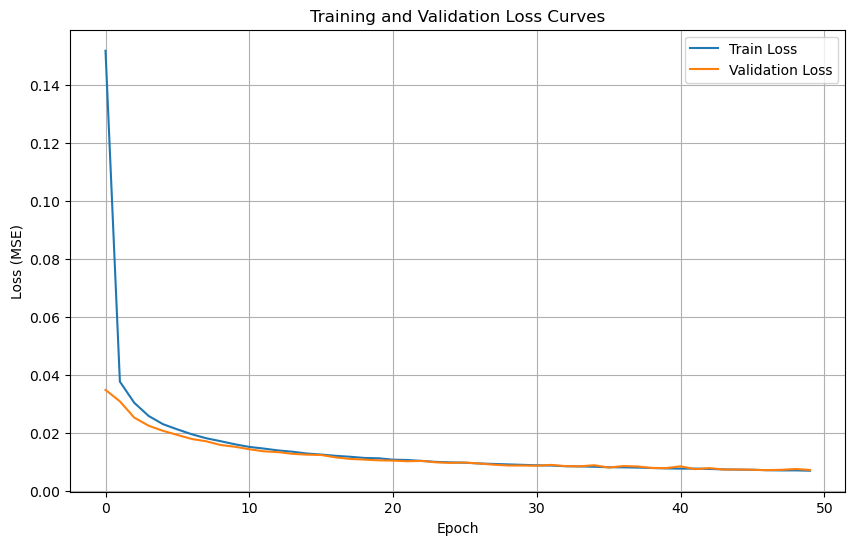

In [57]:
# Training loop for the Vision Transformer
# Collect train/val losses for plotting and debugging

device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model = VisionTransformer().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_epochs = 50
best_val = float('inf')
train_losses = []
val_losses = []

for epoch in range(1, n_epochs+1):
    # TRAINING
    model.train()
    train_loss = 0.0
    for xb, yb in tqdm(train_dataloader, desc=f'Epoch {epoch} - train', leave=False):
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss = train_loss / (len(train_dataloader.dataset))
    train_losses.append(train_loss)

    # VALIDATION
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in tqdm(validation_dataloader, desc=f'Epoch {epoch} - val', leave=False):
            xb = xb.to(device)
            yb = yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss = val_loss / (len(validation_dataloader.dataset))
    val_losses.append(val_loss)

    print(f'Epoch {epoch}: train_loss={train_loss:.6f} val_loss={val_loss:.6f}')

    # checkpoint
    if val_loss < best_val:
        best_val = val_loss
        torch.save({'model_state': model.state_dict(), 'optimizer_state': optimizer.state_dict(), 'epoch': epoch}, 'vit_best.pth')

# Final test evaluation
model.eval()
test_loss = 0.0
with torch.no_grad():
    for xb, yb in test_dataloader:
        xb = xb.to(device)
        yb = yb.to(device)
        out = model(xb)
        loss = criterion(out, yb)
        test_loss += loss.item() * xb.size(0)
test_loss = test_loss / (len(test_dataloader.dataset))
print('Test loss:', test_loss)

# Save final model weights
torch.save(model.state_dict(), 'vit_final.pth')

# Plot loss curves for debugging
def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(10,6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_curves(train_losses, val_losses)


## 6. Evaluation and Visualization

After training, the model is evaluated on the test set. RMSE is computed, and sample predictions are visualized to assess model performance.

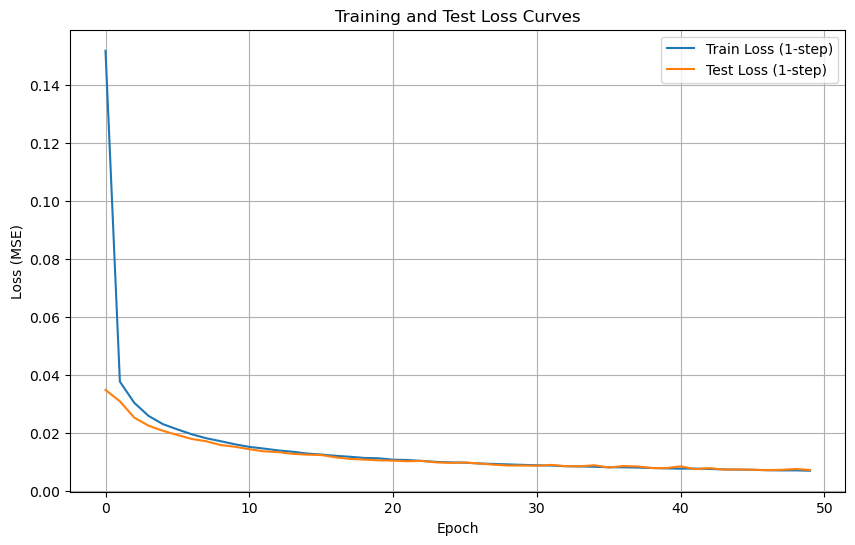

Test RMSE (1-step): 0.0847

Example predictions for 1-step ahead model


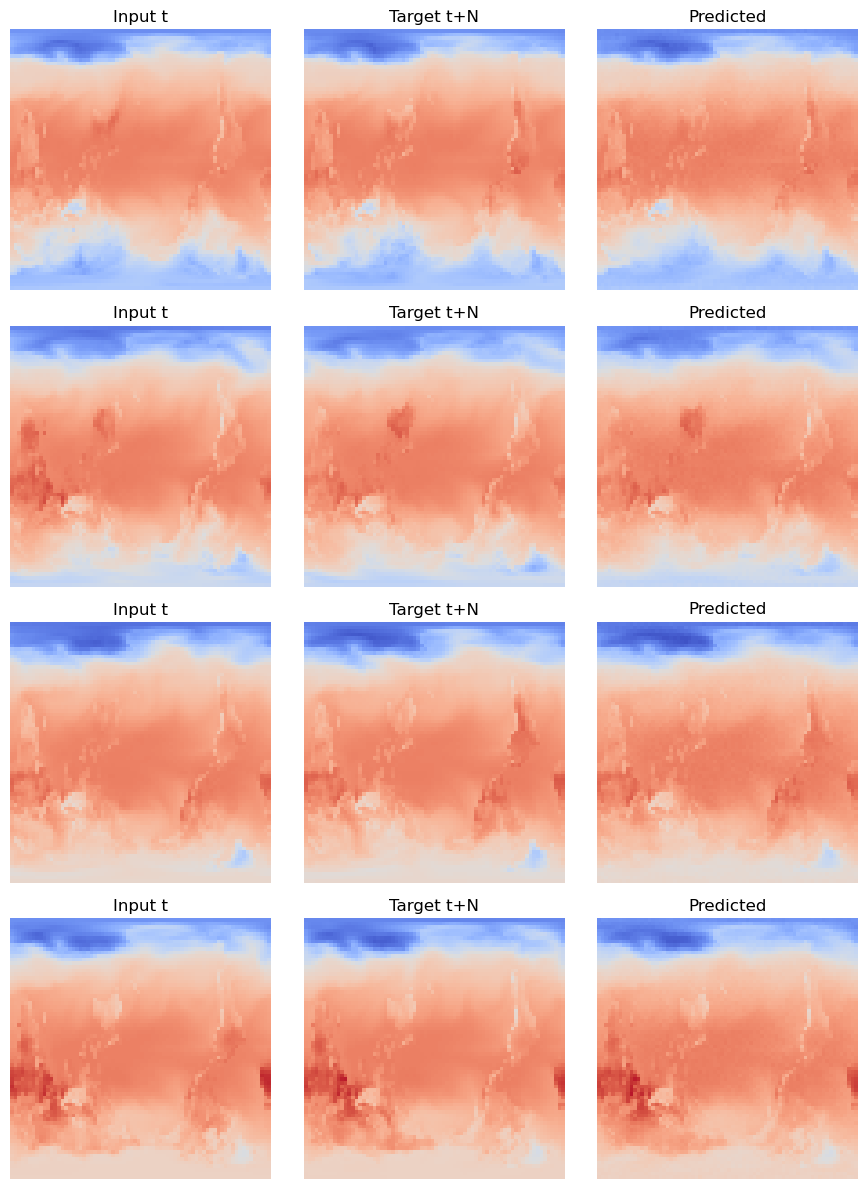

In [58]:
# Plotting losses, compute RMSE on test sets and show sample predictions
import math

def plot_loss_curves():
    plt.figure(figsize=(10,6))
    plt.plot(train_losses, label='Train Loss (1-step)')
    plt.plot(val_losses, label='Test Loss (1-step)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Test Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

from sklearn.metrics import mean_squared_error

def compute_rmse(model, test_loader, device):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            out = model(data)
            preds.append(out.cpu().numpy())
            trues.append(target.cpu().numpy())
    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)
    # compute RMSE per pixel then mean
    rmse = math.sqrt(mean_squared_error(trues.ravel(), preds.ravel()))
    return rmse, preds, trues


def show_sample_predictions(model, test_loader, device, n_examples=4, cmap='coolwarm'):
    model.eval()
    data_iter = iter(test_loader)
    data_batch, target_batch = next(data_iter)
    data_batch = data_batch.to(device)
    target_batch = target_batch.to(device)
    with torch.no_grad():
        pred_batch = model(data_batch)
    # move to cpu and numpy
    inp = data_batch.cpu().numpy()
    tgt = target_batch.cpu().numpy()
    pred = pred_batch.cpu().numpy()

    n = min(n_examples, inp.shape[0])
    vmin = min(inp.min(), tgt.min(), pred.min())
    vmax = max(inp.max(), tgt.max(), pred.max())

    fig, axes = plt.subplots(n, 3, figsize=(9, 3*n))
    if n == 1:
        axes = np.expand_dims(axes, 0)
    for i in range(n):
        axes[i,0].imshow(inp[i,0], cmap=cmap, vmin=vmin, vmax=vmax)
        axes[i,0].set_title('Input t')
        axes[i,0].axis('off')

        axes[i,1].imshow(tgt[i,0], cmap=cmap, vmin=vmin, vmax=vmax)
        axes[i,1].set_title('Target t+N')
        axes[i,1].axis('off')

        axes[i,2].imshow(pred[i,0], cmap=cmap, vmin=vmin, vmax=vmax)
        axes[i,2].set_title('Predicted')
        axes[i,2].axis('off')
    plt.tight_layout()
    plt.show()

# Run plotting and compute RMSE for each model
plot_loss_curves()

rmse_1, preds_1, trues_1 = compute_rmse(model, test_dataloader, device)


print(f"Test RMSE (1-step): {rmse_1:.4f}")


# Show example predictions for each model
print('\nExample predictions for 1-step ahead model')
show_sample_predictions(model, test_dataloader, device, n_examples=4)


## 7. Per-pixel RMSE Analysis

This section computes and visualizes per-pixel RMSE maps for both train and test sets, providing insight into spatial error distribution and model performance across the grid.

Computing RMSE maps for 1-step model...


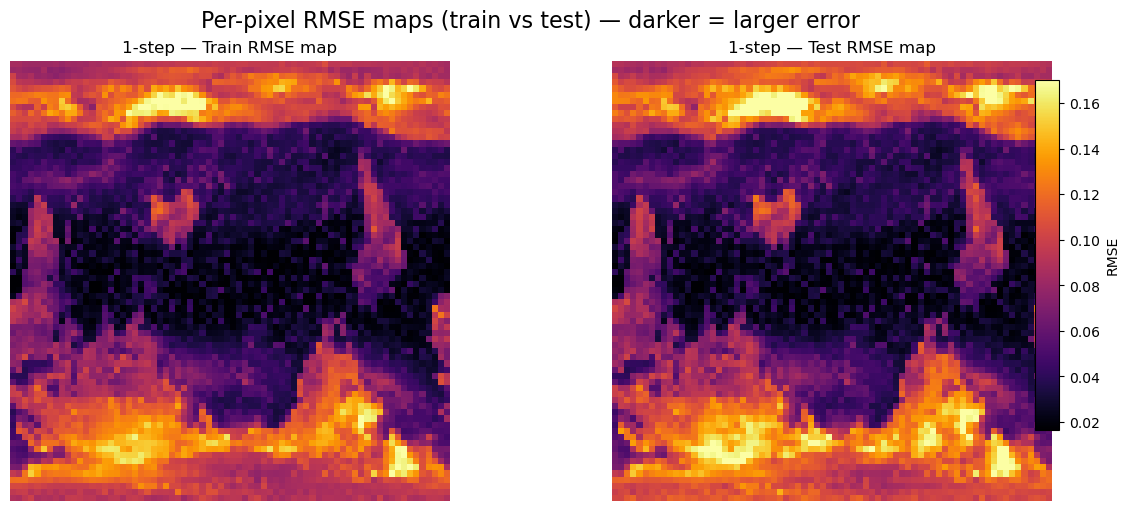

1-step mean RMSE - train: 0.0694, test: 0.0737


In [59]:
# Compute and plot per-pixel RMSE maps (train and test) for each model
# This creates 3×2 plots: rows = models (1-,3-,7-step), cols = [train, test]

def compute_rmse_map(model, dataloader, device):
    """Return per-pixel RMSE map (H, W) computed across all samples in dataloader."""
    model.eval()
    sum_sq = None
    count = 0
    with torch.no_grad():
        for data, target in dataloader:
            # data/target: (batch, 1, H, W)
            data = data.to(device)
            target = target.to(device)
            out = model(data)
            err = (out - target) ** 2  # squared error per pixel
            err_np = err.cpu().numpy()  # shape (batch, 1, H, W)
            if sum_sq is None:
                sum_sq = np.sum(err_np, axis=0)  # shape (1, H, W)
            else:
                sum_sq += np.sum(err_np, axis=0)
            count += err_np.shape[0]

    if count == 0:
        raise ValueError('Dataloader is empty; cannot compute RMSE map')

    mse_map = sum_sq / count  # shape (1, H, W)
    rmse_map = np.sqrt(mse_map)[0]  # drop channel -> (H, W)
    return rmse_map

# Compute maps for each model / dataset
maps = []  # [(model_name, train_map, test_map)]
models_info = [
    ('1-step', model, train_dataloader, test_dataloader)
    ]

for name, model, train_loader, test_loader in models_info:
    print(f'Computing RMSE maps for {name} model...')
    train_map = compute_rmse_map(model, train_loader, device)
    test_map = compute_rmse_map(model, test_loader, device)
    maps.append((name, train_map, test_map))

# Determine common color scale for comparability
all_vals = np.concatenate([m[1].ravel() for m in maps] + [m[2].ravel() for m in maps])
vmax = np.percentile(all_vals, 99)  # robust max (99th percentile)
vmin = np.percentile(all_vals, 1)

# Plot 1x2 grid (train and test maps side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
for name, train_map, test_map in maps:
    im0 = axes[0].imshow(train_map, cmap='inferno', vmin=vmin, vmax=vmax)
    axes[0].set_title(f'{name} — Train RMSE map')
    axes[0].axis('off')

    im1 = axes[1].imshow(test_map, cmap='inferno', vmin=vmin, vmax=vmax)
    axes[1].set_title(f'{name} — Test RMSE map')
    axes[1].axis('off')

# Add a single colorbar on the right
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im1, cax=cbar_ax, label='RMSE')

plt.suptitle('Per-pixel RMSE maps (train vs test) — darker = larger error', fontsize=16)
plt.show()

# Print mean RMSE per model/dataset for convenience
for name, train_map, test_map in maps:
    print(f"{name} mean RMSE - train: {train_map.mean():.4f}, test: {test_map.mean():.4f}")
